# Stage 2b: Generate AI Alpha Factors

- Compute target values (y)
    - Quantize with 2 bins for testing
    - Quantize with 25 bins for production
- Train model for Feature importance
- Feature reduction
- Train model for AI Alpha Vector
- Compute AI Alpha Vectors for 1 year
- Save AI Alpha Vectors

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

# Price History data from Stage 1

In [3]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks')
print(pricing.columns.to_list())
pricing.tail()

Date range for price histories: 2016-09-02 to 2021-09-02
You have 436 stocks
['A', 'AAL', 'AAP', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AMGN', 'AMP', 'AMT', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHTR', 'CI', 'CINF', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DG', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DOV', 'DOW', 'DPZ', 'DRE', 'DRI', 'DTE', 'DUK',

ticker,A,AAL,AAP,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2021-08-27 00:00:00+00:00,173.81,20.220,203.82,119.58,124.59,335.66,658.52,166.48,60.57,208.96,...,101.05,68.70,156.27,55.770,134.94,131.70,150.07,587.96,58.55,203.82
2021-08-30 00:00:00+00:00,176.73,19.510,201.14,120.57,125.94,337.00,665.99,166.98,60.07,209.07,...,99.89,69.03,155.07,55.160,136.48,130.69,149.78,584.78,57.20,205.89
2021-08-31 00:00:00+00:00,175.47,19.940,202.85,120.78,126.37,336.56,663.70,162.95,60.00,209.04,...,101.69,68.75,155.59,54.520,136.31,131.03,150.45,587.17,57.90,204.56
2021-09-01 00:00:00+00:00,175.45,19.640,201.88,112.27,127.40,337.90,665.89,161.11,59.66,206.86,...,100.98,69.75,154.47,53.770,136.55,131.55,150.87,582.78,57.17,206.44
2021-09-02 00:00:00+00:00,177.66,19.755,201.14,111.36,127.95,340.31,663.54,162.19,59.93,206.27,...,102.10,70.07,153.60,54.985,137.30,131.16,148.99,587.92,57.07,208.55


## Read existing factors

## Compute the target values (y) and Shift back to create a 5 day forward prediciton

This is something you want to experiment with. If you are planning on holding on to assets for long periods of time, perhaps a 20, 40 or 60 forward prediciton will work better.

In [4]:
prod_target_source = '5Day2Quant'
prod_target_quantiles = 2
forward_prediciton_days = 5

all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
print(f'Stocks: {all_assets}')
all_factors.sort_values(['ticker', 'date']).tail(10)
features = all_factors.columns.tolist()

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, prod_target_quantiles, forward_prediciton_days).for_al(prod_target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[prod_target_source].shift(-forward_prediciton_days)
all_factors[[prod_target_source,'target']].reset_index().sort_values(['ticker', 'date']).tail(10)

Factors from date: 2016-10-28 00:00:00+00:00 to date: 2021-09-02 00:00:00+00:00
Stocks: ['A', 'AAL', 'AAP', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AMGN', 'AMP', 'AMT', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHTR', 'CI', 'CINF', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DG', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DOV', 'DOW', 'DPZ', 'DRE', 'DRI', 'D

overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2016-10-28 00:00:00+00:00 A                                -0.528356   
                          AAL                              -1.124247   
                          AAP                              -1.465891   
                          ABBV                              0.131096   
                          ABT                              -1.402330   

                                  mean_reversion_5_day_logret  \
date                      ticker                                
2016-10-28 00:00:00+00:00 A                          1.386445   
                          AAL                       -0.520413   
                          AAP                        0.305892   
                          ABBV                       1.457952   
                          ABT                        0.806442   

                                  annualzed_volatility_20_day  5Day2Quant  
date                      ticker                                           
2016-10-28 00:00:00+00:00 A                          0.981236           0  
                          AAL                        1.465895           1  
                          AAP                       -0.353563           0  
                          ABBV                      -0.576029           0  
                          ABT                        0.623701           0

,date,ticker,5Day2Quant,target
527995,2021-08-20 00:00:00+00:00,ZTS,1,0.0
528431,2021-08-23 00:00:00+00:00,ZTS,1,0.0
528867,2021-08-24 00:00:00+00:00,ZTS,0,0.0
529303,2021-08-25 00:00:00+00:00,ZTS,0,1.0
529739,2021-08-26 00:00:00+00:00,ZTS,0,1.0
530175,2021-08-27 00:00:00+00:00,ZTS,0,NaN
530611,2021-08-30 00:00:00+00:00,ZTS,0,NaN
531047,2021-08-31 00:00:00+00:00,ZTS,0,NaN
531483,2021-09-01 00:00:00+00:00,ZTS,1,NaN
531919,2021-09-02 00:00:00+00:00,ZTS,1,NaN


### IID Check of Target
Let's see if the returns are independent and identically distributed.

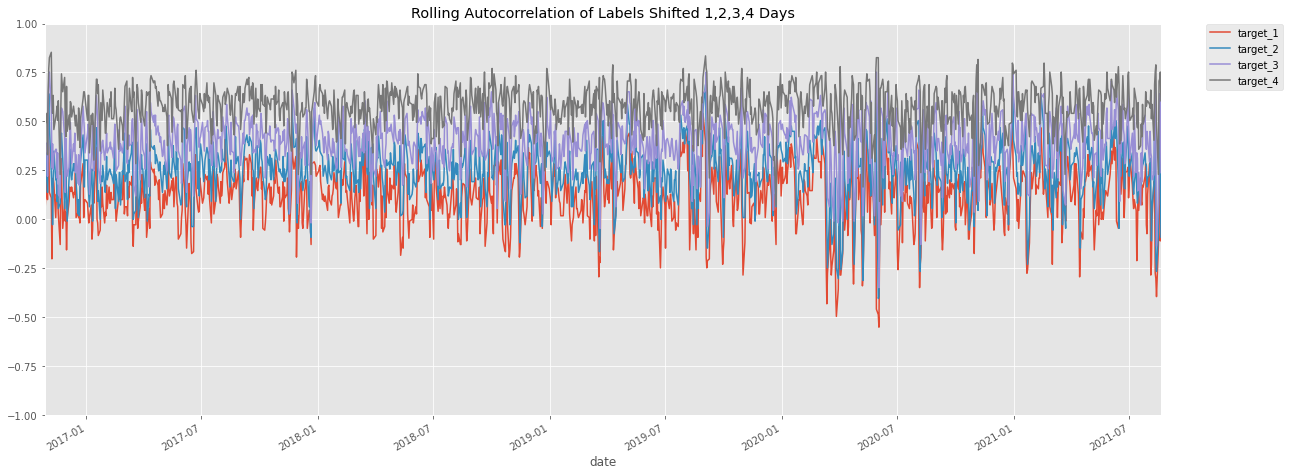

In [5]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_1'] = all_factors.groupby(level='ticker')['target'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level='ticker')['target'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level='ticker')['target'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level='ticker')['target'].shift(-1)

g = all_factors.dropna().groupby(level='date')
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

## Evaluate Autocorrelation IID Results

As you can see, the further out from the target (target_4) we are the less correlated the data is.

In [6]:
all_factors.columns.values

array(['overnight_sentiment_5_day_smoothed',
       'mean_reversion_5_day_logret', 'annualzed_volatility_20_day',
       '5Day2Quant', 'target', 'target_1', 'target_2', 'target_3',
       'target_4'], dtype=object)

In [7]:
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.6, 0.20, 0.20)

X_train.head()

1.0


overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2016-10-28 00:00:00+00:00 A                                -0.528356   
                          AAL                              -1.124247   
                          AAP                              -1.465891   
                          ABBV                              0.131096   
                          ABT                              -1.402330   

                                  mean_reversion_5_day_logret  \
date                      ticker                                
2016-10-28 00:00:00+00:00 A                          1.386445   
                          AAL                       -0.520413   
                          AAP                        0.305892   
                          ABBV                       1.457952   
                          ABT                        0.806442   

                                  annualzed_volatility_20_day  
date                      ticker                               
2016-10-28 00:00:00+00:00 A                          0.981236  
                          AAL                        1.465895  
                          AAP                       -0.353563  
                          ABBV                      -0.576029  
                          ABT                        0.623701

## Build and Train a model to derive our AI generated Alpha
### Build an ensemble of non-overlapping trees
Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [8]:
import abc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

print(f'Sci-Kit version: {sklearn.__version__}')


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        self.estimator = estimator
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        self.feature_importances_ = self.feature_importances(self.estimators_)
        
        return self
    
class NoOverlapVoter(NoOverlapVoterAbstract):
            
    def _calculate_oob_score(self, classifiers):
        oob_scores = []
        for classifier in classifiers:
            oob_scores.append(classifier.oob_score_)

        return np.mean(oob_scores)
    
    def feature_importances(self, classifiers):
        feature_importances = []
        for classifier in classifiers:
            feature_importances.append(classifier.feature_importances_)
            
        return np.mean(feature_importances, axis=0)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        fit_classifiers = []
        for clf_idx in range(len(classifiers)):
            x_samp, y_samp = utils.non_overlapping_samples(x, y, n_skip_samples, clf_idx)
            fit_classifiers.append(classifiers[clf_idx].fit(x_samp, y_samp))

        return fit_classifiers

Sci-Kit version: 0.24.1


#### Train Model

In [9]:
n_days = 10
n_stocks = len(set(all_factors.index.get_level_values(level='ticker').values))
clf_random_state = 42

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_days * n_stocks,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 1000]

Training Models:   0%|          | 0/4 [00:00<?, ?Model/s]

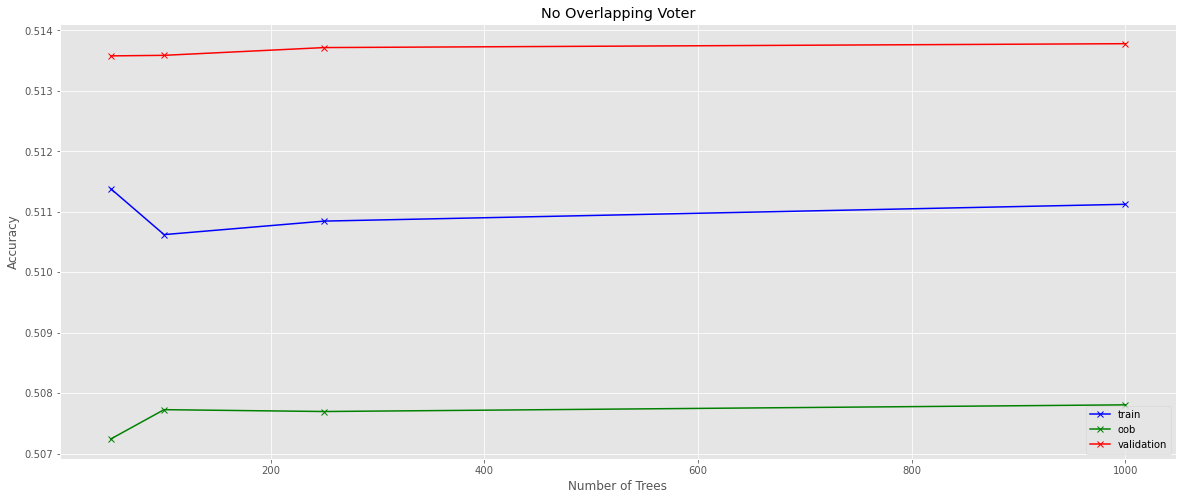

In [10]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf, n_skip_samples=forward_prediciton_days-1)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)
    
utils.plot_results(n_trees_l, train_score, oob_score, valid_score, ['train', 'oob', 'validation'], 'No Overlapping Voter', 'Number of Trees')

In [11]:
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)

      Feature                                Importance
 1. mean_reversion_5_day_logret        (0.365759900891661)
 2. overnight_sentiment_5_day_smoothed (0.35236974983655606)
 3. annualzed_volatility_20_day        (0.281870349271783)


['mean_reversion_5_day_logret']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:

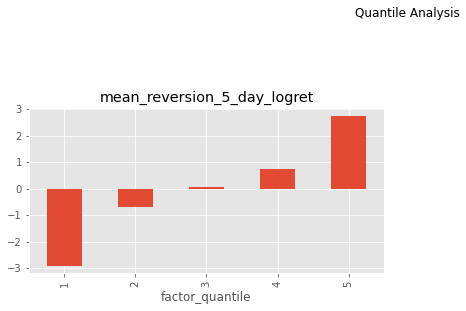

['overnight_sentiment_5_day_smoothed']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


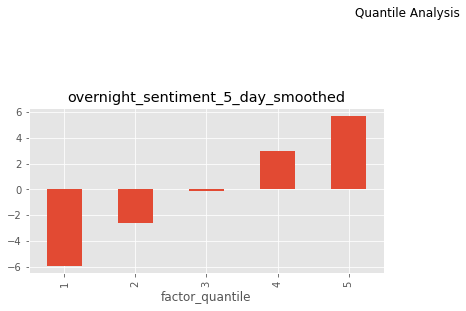

['annualzed_volatility_20_day']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


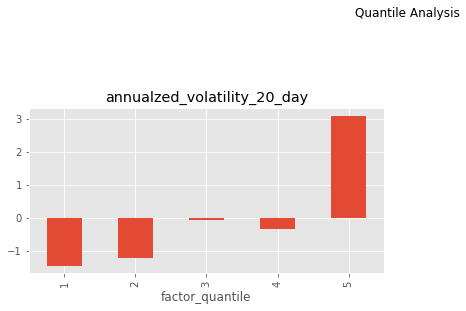

In [12]:
batch_size = 1
for i in range(0,len(ranked_features),batch_size):
    features_to_use = ranked_features[i:i+batch_size]
    print(features_to_use)
    try:
        clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors[features_to_use], pricing)
        alpha_factors.plot_basis_points_per_day_quantile(unixt_factor_data)
        plt.show()
    except:
        print('Issue getting clean factor data')


Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.84
mean_reversion_5_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

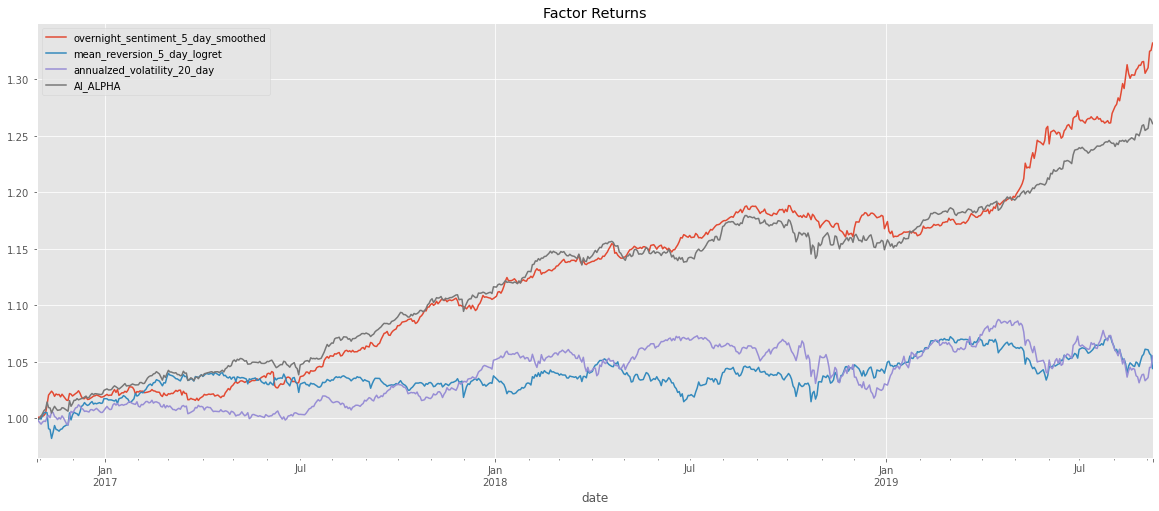

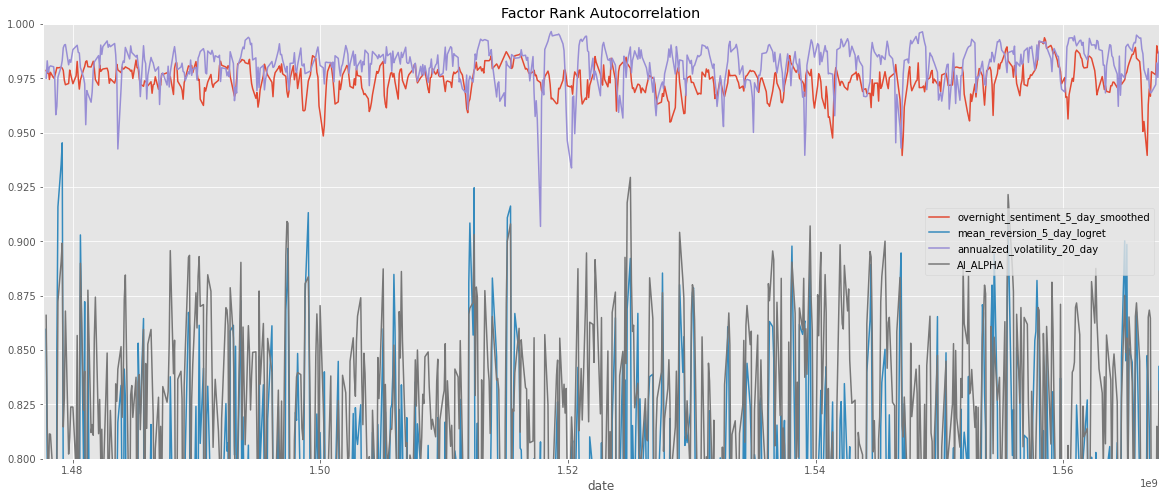

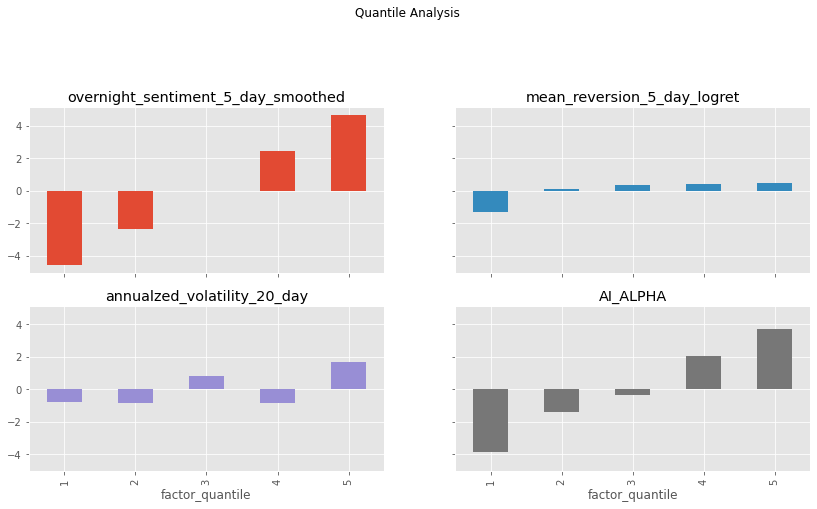

In [14]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, features, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          1.94
mean_reversion_5_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

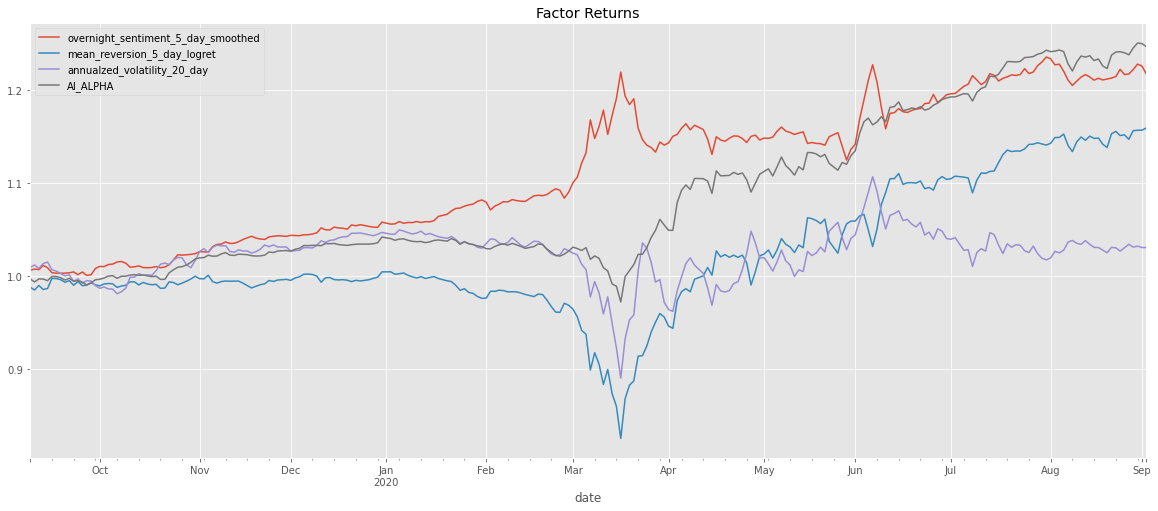

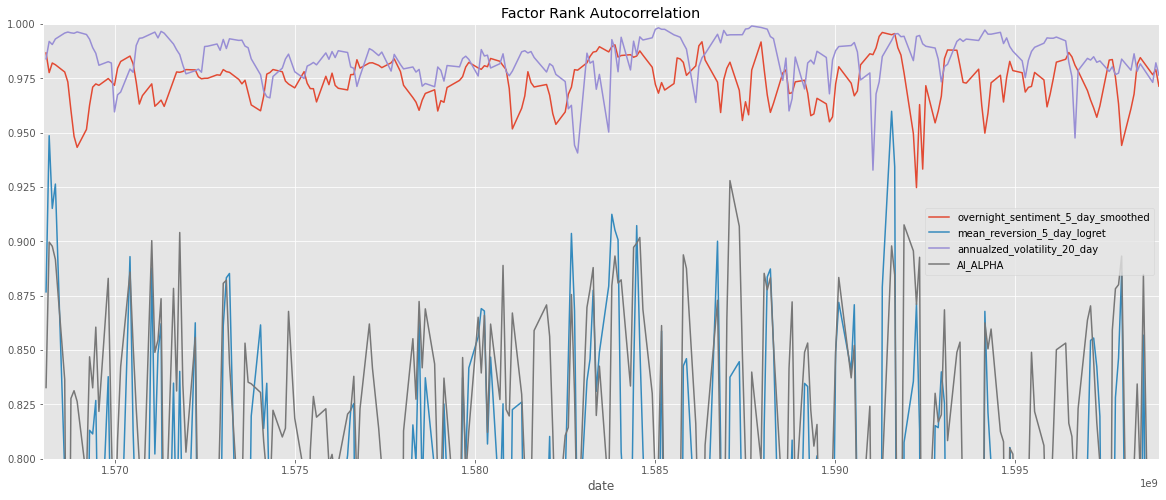

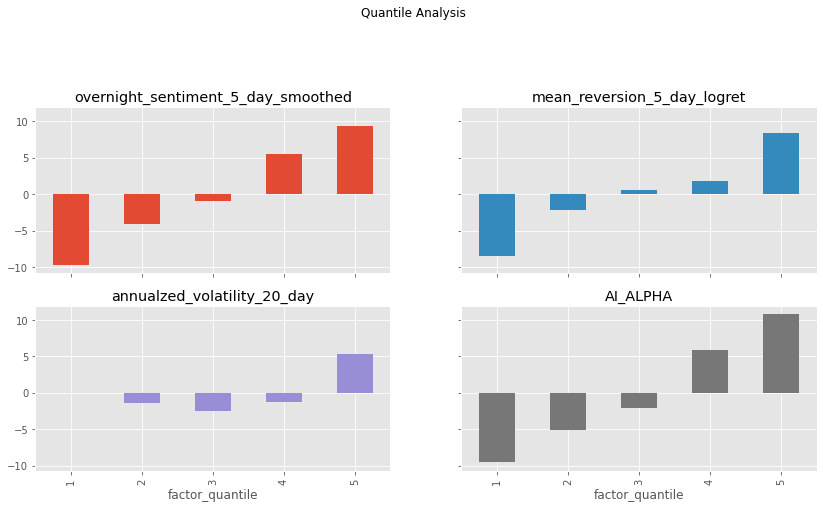

In [15]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, features, pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [16]:
print('Features Ranked by Average Importance:\n')
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)
ranked_features

Features Ranked by Average Importance:

      Feature                                Importance
 1. mean_reversion_5_day_logret        (0.365759900891661)
 2. overnight_sentiment_5_day_smoothed (0.35236974983655606)
 3. annualzed_volatility_20_day        (0.281870349271783)


['mean_reversion_5_day_logret',
 'overnight_sentiment_5_day_smoothed',
 'annualzed_volatility_20_day']

## Read existing factors

In [17]:
temp = all_factors.dropna().copy()
X = temp[features]
y = temp['target']

1.0


In [19]:
clf = RandomForestClassifier(1000, **clf_parameters)

clf_nov = NoOverlapVoter(clf, n_skip_samples=forward_prediciton_days-1)
clf_nov.fit(X, y)

NoOverlapVoter(estimator=RandomForestClassifier(criterion='entropy',
                                                min_samples_leaf=4360,
                                                n_estimators=1000, n_jobs=-1,
                                                oob_score=True,
                                                random_state=42))

### Results
#### Accuracy

In [28]:
print('train: {}, oob: {}'.format(
    clf_nov.score(X, y.values),
    clf_nov.oob_score_))

train: 0.5113504647762483, oob: 0.5082293450053621


Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          1.99
mean_reversion_5_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

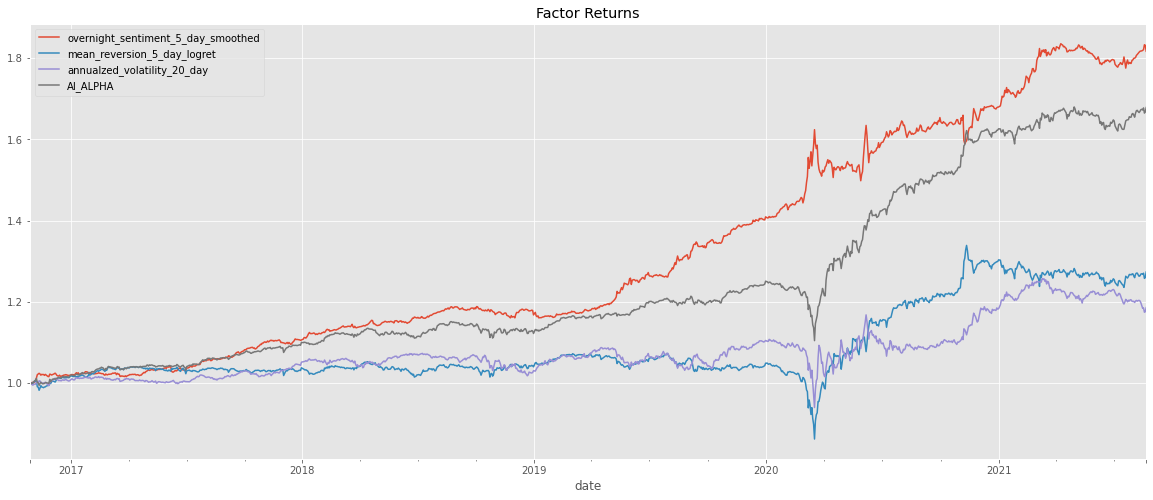

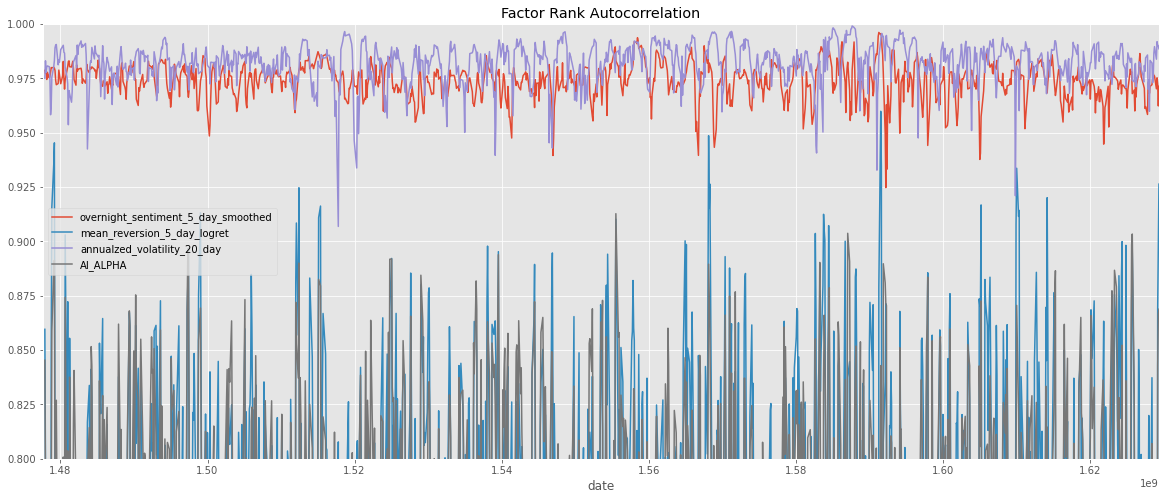

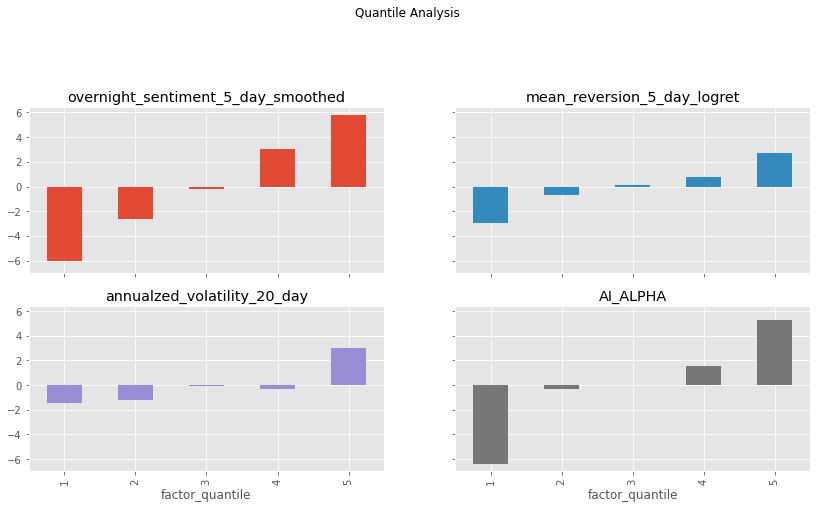

In [21]:
ai_alpha = alpha_factors.evaluate_ai_alpha(all_factors, X, clf_nov, features, pricing)

## Model evaluation

This looks like a pretty good model. Let's generate the alpha vectors for each day and save them

In [22]:
all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')

Factors from date: 2016-10-28 00:00:00+00:00 to date: 2021-09-02 00:00:00+00:00


In [23]:
alpha_scores = alpha_factors.compute_ai_alpha_score(all_factors[features], clf_nov)

In [24]:
ai_alpha = pd.DataFrame(alpha_scores, index=all_factors.index, columns=['AI_ALPHA']).reset_index()
ai_alpha['date'] = ai_alpha['date'].dt.date
alpha_vectors = ai_alpha.reset_index().pivot(index='date', columns='ticker', values='AI_ALPHA')
alpha_vectors

ticker,A,AAL,AAP,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-10-28,0.012327,-0.017340,-0.009533,0.032853,0.002917,-0.023162,0.014718,-0.004824,-0.019659,-0.014852,...,0.009376,-0.019167,-0.019057,-0.001041,-0.004844,-0.003906,0.026599,-0.019408,0.009812,0.025329
2016-10-31,0.022959,-0.020225,-0.018414,0.036849,0.000787,-0.022021,0.026177,0.009166,-0.016060,-0.014089,...,0.019004,-0.020068,-0.009895,0.011785,-0.017365,-0.001582,0.008855,-0.008095,0.006638,0.016329
2016-11-01,-0.007457,-0.018600,-0.002379,0.025121,0.000460,-0.026145,0.015183,0.017186,-0.005106,-0.014203,...,-0.001528,-0.015209,-0.009182,0.007912,-0.013033,-0.002754,0.006423,-0.019785,0.001647,0.015662
2016-11-02,-0.010305,-0.024530,0.004758,0.015776,-0.000456,-0.027647,0.015400,0.000221,-0.001605,-0.015690,...,-0.005233,-0.016059,-0.000918,0.007103,-0.006402,0.009906,0.003614,-0.001586,0.026369,-0.020080
2016-11-03,-0.014678,-0.021188,-0.016187,0.012848,0.006817,-0.028674,-0.000881,-0.004160,-0.008374,-0.014727,...,0.033324,-0.018994,-0.014882,0.006331,-0.018455,0.001743,-0.002774,0.011121,0.037634,-0.014068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,-0.008171,-0.012168,0.014063,-0.002390,0.000300,-0.022408,-0.013032,0.006334,-0.018844,0.015091,...,-0.003381,0.026656,-0.008952,-0.018115,-0.003670,0.004571,-0.000558,-0.003822,-0.025020,0.030932
2021-08-30,-0.015271,-0.001932,0.009862,-0.002133,-0.012815,-0.015818,-0.007866,0.019839,-0.019360,0.029172,...,-0.001204,-0.003720,-0.001873,0.013621,-0.012196,-0.002198,-0.013434,0.009007,-0.015687,0.014439
2021-08-31,-0.007389,0.009418,0.009853,0.003187,-0.013556,-0.006188,-0.007211,0.026689,-0.016762,-0.004686,...,0.003143,-0.012684,-0.008710,0.043102,-0.008942,-0.001511,-0.003207,0.003664,-0.015252,0.012537


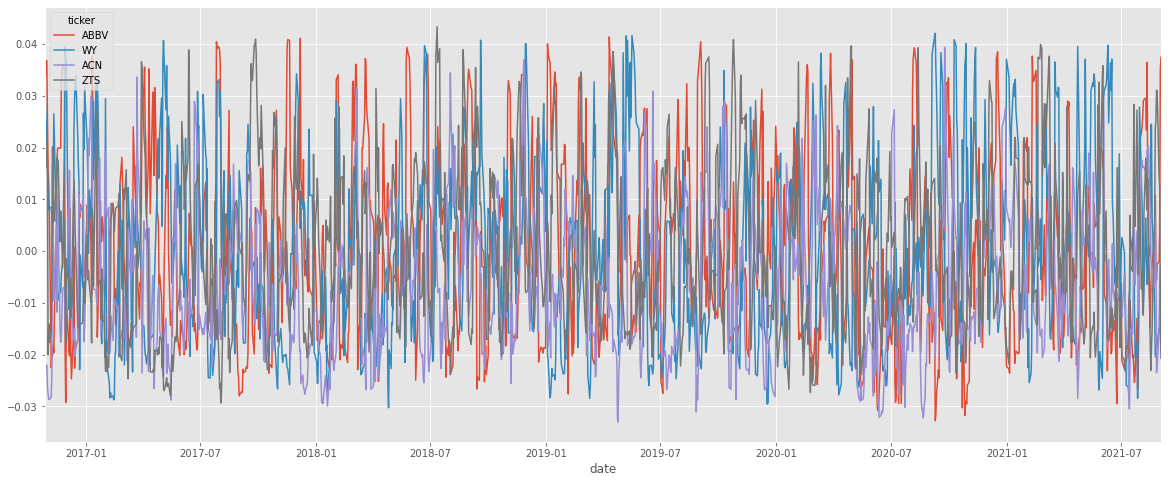

In [25]:
alpha_vectors[['ABBV', 'WY', 'ACN', 'ZTS',]].plot()

In [26]:
alpha_vectors.reset_index().to_csv('data/alpha_vectors.csv', index=False)